<a href="https://colab.research.google.com/github/BBVA/mercury-graph/blob/master/tutorials/mercury-graph-tutorial-banksim.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Table of contents
- [What is `mercury-graph`?](#mercury-graph)
- [Environment setup](#environment-setup)
- [Graph creation](#graph-creation)
- [Graph embeddings](#graph-embeddings)
- [Node2Vec with Spark](#node2vec)
- [Louvain community detection with Spark](#louvain)
- [Spectral clustering](#spectral)
- [Transition matrix (Markov chains)](#transition)
- [Spread activation with Spark](#spread-activation)

# What is `mercury-graph`? <a name="mercury-graph"></a>

**`mercury-graph`** is a Python library that offers **graph analytics capabilities with a technology-agnostic API**, enabling users to apply a curated range of performant and scalable algorithms and utilities regardless of the underlying data framework. The consistent, scikit-like interface abstracts away the complexities of internal transformations, allowing users to effortlessly switch between different graph representations to leverage optimized algorithms implemented using pure Python, [**numba**](https://numba.pydata.org/), [**networkx**](https://networkx.org/) and PySpark [**GraphFrames**](https://graphframes.github.io/graphframes/docs/_site/index.html).

It is a part of [**`mercury`**](https://www.bbvaaifactory.com/mercury/), a collaborative library developed by the **Advanced Analytics community at BBVA** that offers a broad range of tools to simplify and accelerate data science workflows. This library was originally an Inner Source project, but some components, like `mercury.graph`, have been released as Open Source.

Currently implemented **submodules** in `mercury.graph` include:
- [**`mercury.graph.core`**](#graph-creation), with the main classes of the library that create and store the graphs' data and properties.
- **`mercury.graph.ml`**, with graph theory and machine learning algorithms such as [Louvain community detection](#louvain), [spectral clustering](#spectral), [Markov chains](#transition), [spreading activation-based diffusion models](#spread-activation) and graph random walkers.
- **`mercury.graph.embeddings`**, with classes that calculate [graph embeddings](#graph-embeddings) in different ways, such as following the [Node2Vec](#node2vec) algorithm.


# Environment setup <a name="environment-setup"></a>



<div class="alert alert-block alert-info">
<b>Note:</b> This notebook requires Spark and Graphframes, which are installed below.
</div>

In [ ]:
# Mercury-Graph
! pip install mercury-graph

# PySpark - Latest version: 3.5.3, including Spark, already installed in Google Colab
# ! pip install pyspark

# GraphFrames - Latest version: 0.8.3
! pip install graphframes-latest

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.3/462.3 kB 6.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for mercury-graph: filename=mercury_graph-3.2.1-py3-none-any.whl size=466703 sha256=b18bd3efcaf333c7f346847b1baa19e441736ef3a0a05ba411eea75db7dd6547
  Stored in directory: /root/.cache/pip/wheels/5a/95/5a/875286fc4b346d364b10ad8d61ebc99c0a2e15d321e4a59383
Successfully built mercury-graph
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 4.4 MB/s eta 0:00:00
  Created wheel for graphframes-latest: filename=graphframes_latest-0.8.3-py3-none-any.whl size=21228 sha256=328de95a454976fabe9eb22ec8a72a0b9a655088f3b8e52455a1a402422f5153
  Stored in directory: /root/.cache/pip/wheels/9d/2d/15/2c073852bec997aafdd4c5625db7e522573a333c7123144b61
Successfully built graphframes-latest


From `mercury.graph`, we first **import**:

- **`Graph`**, to create graphs **from pandas/Spark dataframes or from networkx/graphframes graph objects**. It is the core class of the library, storing the graphs' data and properties and offering a **flexible and technology-agnostic API**.
- **`SparkInterface`**, to initialize a new Spark session or get an existing one.

In [ ]:
import os
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="pyspark")

import numpy as np
import pandas as pd
pd.set_option('display.max_colwidth', None)

import matplotlib.pyplot as plt
import seaborn as sns

import networkx as nx

from mercury.graph.core import Graph, SparkInterface

import pyspark.sql.functions as f

When creating the Spark session, we must specify the graphframes jar package to be installed, loaded and used (the library installed above provides the Python API).

In [ ]:
os.environ["PYSPARK_SUBMIT_ARGS"] = "--packages graphframes:graphframes:0.8.3-spark3.5-s_2.12 pyspark-shell"
spark = SparkInterface().spark

It may also be useful to display the Spark UI in order to track resource usage within Spark.

In [ ]:
# View Spark UI in Google Colab
from google.colab import output
output.serve_kernel_port_as_iframe(4040, path='/jobs/index.html')

# Deprecated due to browser security updates, but still works and enables opening Spark UI in a new tab:
# output.serve_kernel_port_as_window(4040, path='/jobs/index.html')

# Graph creation <a name="graph-creation"></a>

We will create a graph `g` based on the [**BankSim dataset**](https://www.researchgate.net/publication/265736405_BankSim_A_Bank_Payment_Simulation_for_Fraud_Detection_Research), which contains **synthetic transactional data**. Each row of the dataset represents a generated transaction from a customer to a merchant, and a flag that indicates if the transaction has been detected as fraudulent. Customer IDs begin with 'C' and merchants IDs with 'M'.

In [ ]:
df = pd.read_csv("https://raw.githubusercontent.com/atavci/fraud-detection-on-banksim-data/refs/heads/master/Data/synthetic-data-from-a-financial-payment-system/bs140513_032310.csv",
                 quotechar ="'")

print(f"Number of rows: {len(df)}")
df.head()

Number of rows: 594643


,step,customer,age,gender,zipcodeOri,merchant,zipMerchant,category,amount,fraud
0,0,C1093826151,4,M,28007,M348934600,28007,es_transportation,4.55,0
1,0,C352968107,2,M,28007,M348934600,28007,es_transportation,39.68,0
2,0,C2054744914,4,F,28007,M1823072687,28007,es_transportation,26.89,0
3,0,C1760612790,3,M,28007,M348934600,28007,es_transportation,17.25,0
4,0,C757503768,5,M,28007,M348934600,28007,es_transportation,35.72,0


Let's obtain **which nodes are involved in a transaction that was marked as fraud**:

In [ ]:
fraud_ids = df[df["fraud"] == 1]["customer"].unique().tolist()
print(f"Number of customers involved in a transaction marked as fraud: {len(fraud_ids)}")

Number of customers involved in a transaction marked as fraud: 1483


For each transaction, only the customer, merchant, amount and fraud columns will be kept and considered to build the nodes and edges of the graph. Given that there may be several transactions of different categories between two nodes (customer and merchant), these **transactions will be aggregated to keep only one edge between each pair of nodes**.

The dataset as-is represents the interaction flows from customers to merchants. In this tutorial, we will also create the **reversed edges**, from merchants to customers. In this way, when using algorithms that depend on random walks, paths from merchants to customers will also be allowed.

In [ ]:
df_edges = df[["customer", "merchant", "amount"]] \
              .groupby(["customer", "merchant"]) \
              .agg({"amount": "sum"}) \
              .reset_index()

df_edges_reversed = pd.DataFrame()
df_edges_reversed["customer"] = df_edges["merchant"].values
df_edges_reversed["merchant"] = df_edges["customer"].values
df_edges_reversed["amount"] = df_edges["amount"].values

df_edges = pd.concat([df_edges, df_edges_reversed])
del df_edges_reversed

print(f"Number of edges: {len(df_edges)}")

Number of edges: 94264


Fraud will be considered as a node attribute, highlighting customers that were involved in a fraudulent transaction.

In [ ]:
df_nodes = pd.DataFrame(df_edges["customer"].unique(), columns=["node_id"])
df_nodes["fraud"] = 0
df_nodes.loc[df_nodes["node_id"].isin(fraud_ids), "fraud"] = 1

print(f"Number of nodes: {len(df_nodes)}")

Number of nodes: 4162


In [ ]:
g = Graph(data=df_edges,
          nodes=df_nodes,
          keys={"src": "customer",
                "dst": "merchant",
                "weight": "amount",
                "id": "node_id"})

print(g)

mercury.graph.core.Graph with 4162 nodes and 94264 edges.
  is_directed:    True
  is_weighted:    True
  has_networkx:   True
  has_graphframe: False
  has_dgl:        False


# Graph embeddings <a name="graph-embeddings"></a>

Class `GraphEmbeddings` of mercury.graph.embeddings creates an **embedding mapping the nodes of a graph by doing random walks**, implemented using numpy and networkx. These walks start from a random node and select the edges with a probability that is proportional to the **weight** of the edge.

In [ ]:
from mercury.graph.embeddings import GraphEmbedding

In [ ]:
ge = GraphEmbedding(dimension=100,
                    n_jumps=500000,
                    max_per_epoch=50000,
                    learn_step=2,
                    bidirectional=True)

print(ge)

Object of class GraphEmbedding.

Initialization parameters: bidirectional=True, dimension=100, learn_step=2, load_file=None, max_per_epoch=50000, n_jumps=500000


In [ ]:
ge.fit(g)

GraphEmbedding(bidirectional=True, dimension=100, learn_step=2, load_file=None, max_per_epoch=50000, n_jumps=500000)

After fitting the object to the subgraph, an `Embedding` object is created, containing the representation of the vector embeddings matrix.

In [ ]:
print(ge.embedding(), "\n")

ge_em_np = ge.embedding().as_numpy()
print(f"Shape: {ge_em_np.shape} \n")
print(ge_em_np)

Object of class Embeddings.

Initialization parameters: bidirectional=True, dimension=100, learn_step=2, mean=0, num_elements=4162, sd=1 

Shape: (4162, 100) 

[[-0.18101342  0.16648301  0.48746278 ...  0.16724248 -1.3319061
   0.04977818]
 [ 0.30421709 -1.12771291 -0.10061795 ... -0.90017145  0.56325241
  -0.25189604]
 [ 0.22290183 -0.3205625   0.05670149 ... -0.3423102  -0.26111694
  -0.58992606]
 ...
 [-0.21259568  0.39229359  0.68602042 ...  0.51614339 -0.12808767
   0.48519021]
 [-0.54783869  0.15435938  0.68330632 ...  0.65406794 -1.10278125
   0.09268239]
 [-0.5285175  -0.22113376  0.10913581 ... -0.02046802  0.12340926
  -0.23400463]]


For each node, the **most similar nodes and the similarity metric** (by default, cosine similarity) can be obtained using method `get_most_similar_nodes`. Essentially, it fetches the most similar embeddings using the underlying `Embedding` object.

Let's get the most similar nodes to a node (customer) that was involved in two fraudulent transactions:

In [ ]:
customer_id = "C967956630"

df[(df["customer"]==customer_id) & (df["fraud"]==1)]

,step,customer,age,gender,zipcodeOri,merchant,zipMerchant,category,amount,fraud
255168,85,C967956630,3,M,28007,M980657600,28007,es_sportsandtoys,201.07,1
418587,132,C967956630,3,M,28007,M480139044,28007,es_health,290.27,1


In [ ]:
similar_embeddings = ge.get_most_similar_nodes(customer_id, 10)
similar_embeddings

,word,similarity
0,C626305923,0.497810
1,C825622087,0.497286
2,C1986701933,0.488455
3,C915430510,0.484330
4,C1180936672,0.468207
5,C1545977603,0.465770
6,C632538178,0.464966
7,C73726310,0.464809
8,C1867566140,0.454632
9,C1769470125,0.448841


We can observe that many of the most similar customers were also involved in fraudulent transactions.

In [ ]:
df[df["customer"].isin(similar_embeddings["word"].tolist())].groupby("customer").agg(fraud=("fraud", lambda x: x.sum() >= 1))

,fraud
customer,
C1180936672,True
C1545977603,True
C1769470125,False
C1867566140,True
C1986701933,True
C626305923,True
C632538178,True
C73726310,True
C825622087,True


Now we can obtain the embeddings of the nodes. Let's create a dataframe with the embeddings and also mark which nodes were in a transaction that was marked as fraud:

In [ ]:
ge_em_df = pd.DataFrame({"vector": [v for v in ge_em_np]})

ge_em_df["customer"] = list(g.networkx.nodes)
ge_em_df["fraud"] = 0
ge_em_df.loc[ge_em_df["customer"].isin(fraud_ids), "fraud"] = 1

ge_em_df.head(1)

,vector,customer,fraud
0,"[-0.18101342341388854, 0.16648300512699127, 0.48746278061950826, -1.5088129161472916, -0.48031887224315745, -0.8296314188207013, 1.568987711228516, -0.6798958511850728, -2.402277032144529, -0.4874993532492076, 0.008235820839503239, 0.3742034884198001, -0.37695589599131735, 0.589940489381834, 0.7349978013143029, -0.12866771200436777, 1.6272587667010572, -0.10548539515087527, 1.0617733999746017, 0.013985797798444739, 0.701914815935739, -1.1418679918240935, -1.4657223529048706, 0.02799255318994731, -0.06919132982549783, 0.26056867714521614, -0.31681999487046875, 0.703993321255556, 1.8246240075963132, 1.2437264708155278, 0.3378230694414261, -1.659506040078464, -0.3000505979105364, -1.5416218947658882, -1.20114553851816, -0.18342334178597472, 0.34358306234136604, 0.8685754193282832, -0.5820204733109605, -0.8397560049152125, 0.1375438076341814, 0.837883716465775, -0.010228362205216942, -0.9488229641625756, 0.17170109150433907, 0.2752854401283615, -0.48733484784832354, 1.0746504068104046, -0.08703899012393596, -0.568407768641689, -1.825059678640646, 0.9213115286211274, 0.17341187045527398, -0.7912002736192754, 1.7675142101057337, -0.2559001221165711, 0.002420982075127666, -0.8910389596119606, 0.7060385490860964, 0.4534385840585189, -1.443400224837971, 0.497075247446241, -0.8944480287515411, 1.066642078487758, 0.35394862932162774, -0.0672303167391712, 0.35353188952238285, -0.15051205554571512, -0.2718956655517521, 0.3800551133838127, -0.07753425772981742, 1.6295928975394218, 1.2280497552434995, -0.05238793913700247, -0.430940886852478, 0.7446740662185425, -1.198173931869923, 0.5727215550935215, -0.43799249750863284, -1.0337668234231354, -0.7388044110409658, 2.584787322055334, 2.2750310099407804, -1.08949904795362, -1.539299634301297, -0.16892924099699447, 0.7650583979249264, 1.2684606353801937, -1.429708303565226, -0.6999526317478837, 1.0181449976140826, -0.5083992323701836, -0.03852044145230164, -0.4977047821057456, -1.0361328164995738, -0.7195545042610855, -1.2074494805230245, 0.16724247623635574, -1.3319060989850542, 0.04977817930108629]",C1000148617,1


[TSNE](https://scikit-learn.org/1.5/modules/generated/sklearn.manifold.TSNE.html) can be used to reduce the embedding dimension to two, making it easier to create visualizations. Let's visualize the node embeddings, using the color to see which nodes were involved in transactions marked as fraudulent. We can see that, in general, a lot of those nodes are located in a separate area of the embedding space:

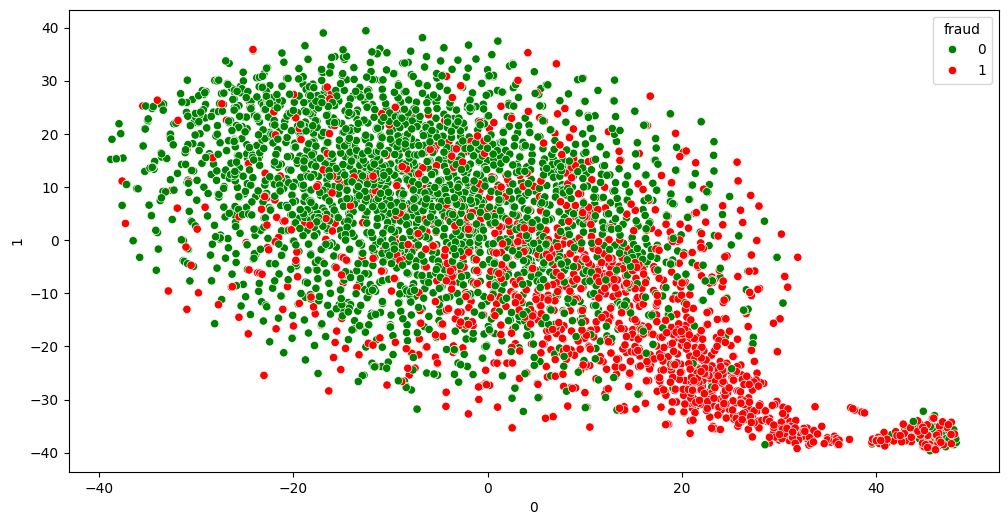

In [ ]:
from sklearn.manifold import TSNE

ge_tsne = TSNE(perplexity=12.0, metric='euclidean', random_state=1)
ge_tsne_np = ge_tsne.fit_transform(np.stack(ge_em_df["vector"].values))

ge_tsne_pd = pd.DataFrame(ge_tsne_np)
ge_tsne_pd["fraud"] = ge_em_df["fraud"].values

fig, axes = plt.subplots(1, 1, figsize=((12,6)))
ax = sns.scatterplot(x=0, y=1,
                     hue="fraud", palette={0: "green", 1: "red"},
                     data=ge_tsne_pd)

# Node2Vec with Spark <a name="node2vec"></a>

`SparkNode2Vec` in `mercury.graph.embeddings` also creates an embedding mapping the nodes of a graph using the scalable **Node2Vec** algorithm (see paper [here](https://www.semanticscholar.org/paper/node2vec%3A-Scalable-Feature-Learning-for-Networks-Grover-Leskovec/36ee2c8bd605afd48035d15fdc6b8c8842363376)). This class follows a similar approach to and has an API consistent with the `GraphEmbedding` class, but with some differences:
  - It uses **Spark** end-to-end (and graphframes as the starting point) rather than an in-memory compiled implementation. This is very useful when using large graph datasets that don't fit in memory.
  - You can load/save the embedding as parquet rather than local pickle files.
  - The embedding algorithm uses the skip-gram model and hierarchical softmax method to train the model rather than rotation in hyperspace.
  - Similarity metrics return differently. (See `.get_most_similar_nodes()` for details.)
  - The embedding is not randomly initialized and exists from scratch. You have to perform random walks to get an embedding or load it from a file.

In [ ]:
from mercury.graph.embeddings import SparkNode2Vec

In [ ]:
n2v = SparkNode2Vec(dimension=100,
                    num_paths_per_node=4,
                    num_epochs=3,
                    w2v_min_count=1)

print(n2v)

Object of class SparkNode2Vec.

Initialization parameters: batch_size=1000000, dimension=100, load_file=None, n_partitions_cache=10, num_epochs=3, num_paths_per_node=4, path_cache=None, sampling_ratio=1.0, use_cached_rw=False, w2v_max_iter=1, w2v_min_count=1, w2v_num_partitions=1, w2v_step_size=0.025


As in `GraphEmbedding`, the graph structure is learnt by performing random walks. However, the number of random jumps is not the given total number. Here, **all nodes** (or a sample of them) start paths up to a maximum number of steps (whenever possible). The process can be forced to restart periodically, which can be effective in addressing the issue of the random walker getting stuck in dead-end nodes, by allowing it to explore other areas of the graph more evenly.

In [ ]:
n2v.fit(g)

SparkNode2Vec(batch_size=1000000, dimension=100, load_file=None, n_partitions_cache=10, num_epochs=3, num_paths_per_node=4, path_cache=None, sampling_ratio=1.0, use_cached_rw=False, w2v_max_iter=1, w2v_min_count=1, w2v_num_partitions=1, w2v_step_size=0.025)

The nodes covered in each random walk can also be inspected.

In [ ]:
print(f"Number of random walks: {n2v.paths_.count()}\n")
n2v.paths_.show(truncate=False)

Number of random walks: 16648

+----------------------------------------------------+
|random_walks                                        |
+----------------------------------------------------+
|[C1000148617, M1823072687, C1049562739, M85975013]  |
|[C100045114, M732195782, C1038277619, M17379832]    |
|[C1000699316, M1946091778, C2085650948, M1823072687]|
|[C1001065306, M2122776122, C1620127338, M1823072687]|
|[C1002658784, M348934600, C1744280753, M209847108]  |
|[C1002759277, M1823072687, C1292770722, M1823072687]|
|[C1004109477, M349281107, C282411136, M1823072687]  |
|[C1004300450, M1913465890, C868061193, M1823072687] |
|[C1004532392, M348934600, C1188590334, M348934600]  |
|[C1005126300, M1823072687, C585290792, M1823072687] |
|[C1005495267, M1823072687, C1098443227, M1600850729]|
|[C1005806982, M50039827, C1132392725, M1873032707]  |
|[C1006176917, M1823072687, C1622016247, M1823072687]|
|[C1007572087, M732195782, C179748485, M1198415165]  |
|[C1007790716, M1600850729, C69605

The embedding can be retrieved completely as a Spark DataFrame, saved, reloaded or queried for similarity.

In [ ]:
n2v.embedding().show(truncate=False)

+-----------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

As with `GraphEmbedding`, method `get_most_similar_nodes` returns a list of nearest neighbors for a given node using cosine similarity.

In [ ]:
print(f"Most similar customers to {customer_id}:\n")
similar_embeddings = n2v.get_most_similar_nodes(customer_id, 10).toPandas()
similar_embeddings

Most similar customers to C967956630:



,word,similarity
0,C195373250,0.959199
1,C1577983313,0.958095
2,C230958403,0.957177
3,C218446443,0.956450
4,C1978250683,0.955759
5,C616715154,0.954969
6,C931370744,0.954852
7,C1273692645,0.954803
8,C723509264,0.954788
9,C806399525,0.952688


Again, many of the most similar customers were also involved in fraudulent transactions.

In [ ]:
df[df["customer"].isin(similar_embeddings["word"].tolist())].groupby("customer").agg(fraud=("fraud", lambda x: x.sum() >= 1))

,fraud
customer,
C1273692645,True
C1577983313,True
C195373250,True
C1978250683,True
C218446443,True
C230958403,True
C616715154,True
C723509264,True
C806399525,True


We can again visualize that nodes with a fraud mark are located in a separate area of the embedding space, leveraging [**TSNE**](https://scikit-learn.org/1.5/modules/generated/sklearn.manifold.TSNE.html) to reduce the embedding dimension to 2.

In [ ]:
n2v_em_df = n2v.embedding().toPandas()

n2v_em_df["fraud"] = 0
n2v_em_df.loc[n2v_em_df["word"].isin(fraud_ids), "fraud"] = 1

n2v_em_df.head(1)

,word,vector,fraud
0,C1940215857,"[0.0012223285157233477, 0.005580422002822161, -4.9572670832276344e-05, -0.005078511778265238, 0.010309402830898762, 0.035186316817998886, -0.020253023132681847, 0.015665223821997643, -0.04094310849905014, 0.015943652018904686, 0.02263753116130829, 0.00812563393265009, -0.0013348085340112448, 0.042165327817201614, -0.014921409077942371, -0.02275211177766323, 0.0054863328114151955, 0.0006658294587396085, -0.005092521198093891, -0.026930155232548714, 0.026851430535316467, 0.008709486573934555, 0.004501241259276867, 0.0019240578403696418, 0.02713809348642826, -0.0020969135221093893, 0.0032299659214913845, 0.020613575354218483, 0.013004201464354992, -0.026220442727208138, 0.011673841625452042, -0.004089518915861845, -0.010345042683184147, -0.03173520043492317, 0.006269850302487612, 0.0035377161111682653, 0.020824790000915527, 0.03513377532362938, -0.0003911859239451587, -0.003994266502559185, -0.0036846480797976255, -0.014898397959768772, -0.04020114988088608, 0.0014803638914600015, -0.0038243215531110764, 0.03474530950188637, 0.00960268173366785, 0.005219549871981144, 0.011121617630124092, 0.024639153853058815, -0.005175327882170677, 0.03958621621131897, -0.006029780954122543, 0.01913345791399479, -0.012330076657235622, -0.011069424450397491, 0.004012909717857838, -0.015445168130099773, -0.031043197959661484, -0.019022773951292038, 0.008634114637970924, 0.035978417843580246, 0.02136884815990925, -0.021931972354650497, 0.038734596222639084, 0.01323588564991951, -0.002145834267139435, -0.007009337656199932, 0.011497900821268559, 0.023674624040722847, -0.0033914537634700537, -0.00900747999548912, 0.014760567806661129, 0.012773859314620495, 0.005281007848680019, 0.006536027882248163, 0.008306307718157768, -0.003634585766121745, -0.013083448633551598, -0.013805368915200233, 0.0022510564886033535, 0.00850948877632618, 0.026793144643306732, -0.029878929257392883, -0.007622540462762117, 0.03703148663043976, -0.0016449897084385157, 0.0228267852216959, -0.01459665596485138, 0.002623076317831874, -0.01140307541936636, -0.01260637678205967, 0.010983733460307121, -0.0037910088431090117, 0.011104783974587917, 0.00047850480768829584, 0.026600850746035576, -0.005465306807309389, -0.004201964475214481, 0.03372158482670784]",0


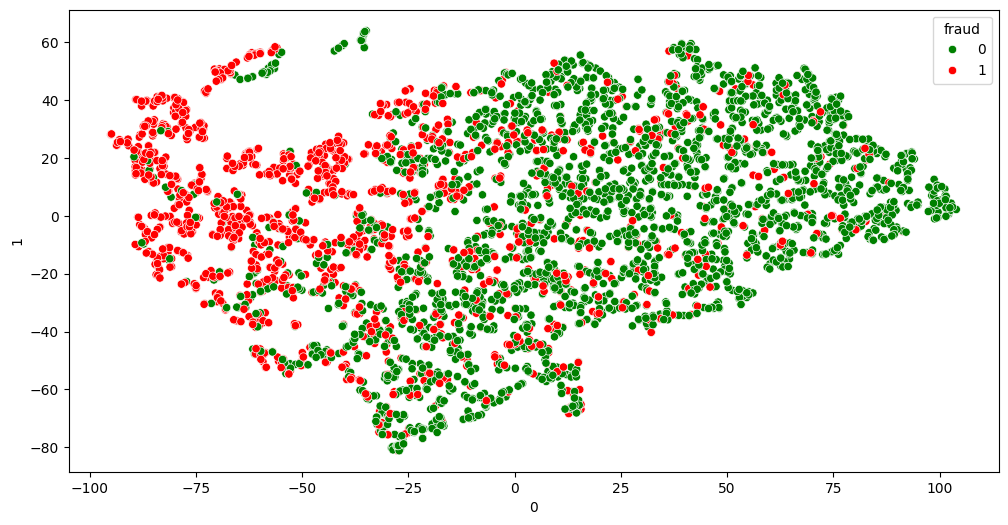

In [ ]:
from sklearn.manifold import TSNE

n2v_tsne = TSNE(perplexity=12.0, metric='euclidean', random_state=1)
n2v_tsne_np = n2v_tsne.fit_transform(np.stack(n2v_em_df["vector"].values))

n2v_tsne_df = pd.DataFrame(n2v_tsne_np)
n2v_tsne_df["fraud"] = n2v_em_df["fraud"].values
n2v_tsne_df["id"] = n2v_em_df["word"].values

fig, axes = plt.subplots(1, 1, figsize=((12,6)))
ax = sns.scatterplot(x=0, y=1,
                     hue="fraud", palette={0: "green", 1: "red"},
                     data=n2v_tsne_df)

Finally, the embedding can be saved using `n2v.save("path/file")`. Saving the embedding to a file allows retrieving it via: `n2v = SparkNode2Vec(load_file = 'path/file')`

# Louvain community detection with Spark <a name="louvain"></a>

Class `LouvainCommunities` from `mercury.graph.ml` can be used to find the **best partition of a graph** through the **Louvain algorithm for community detection** (see paper [here](https://doi.org/10.1088/1742-5468/2008/10/p10008)), implemented using PySpark.

In [ ]:
from mercury.graph.ml import LouvainCommunities

import random

In [ ]:
lc = LouvainCommunities()

print(lc)

Object of class LouvainCommunities.

Initialization parameters: all_partitions=True, max_iter=10, max_pass=2, min_modularity_gain=0.001, resolution=1, verbose=True


In [ ]:
lc.fit(g)

Starting Pass 0 Iteration 0.
Starting Pass 0 Iteration 1.
Starting Pass 0 Iteration 2.
Starting Pass 0 Iteration 3.
Starting Pass 0 Iteration 4.
Starting Pass 0 Iteration 5.
Starting Pass 0 Iteration 6.
Starting Pass 0 Iteration 7.
Starting Pass 0 Iteration 8.
Starting Pass 0 Iteration 9.
Starting Pass 1 Iteration 0.
Starting Pass 1 Iteration 1.
Starting Pass 1 Iteration 2.
Starting Pass 1 Iteration 3.
Starting Pass 1 Iteration 4.
Starting Pass 1 Iteration 5.
Starting Pass 1 Iteration 6.
Starting Pass 2 Iteration 0.


LouvainCommunities(all_partitions=True, max_iter=10, max_pass=2, min_modularity_gain=0.001, resolution=1, verbose=True)

Accessing `.labels_` after fitting shows a DataFrame with the optimal partitions found at the end of each pass.


In [ ]:
lc_df = lc.labels_.toPandas()

lc_df

+-----------+-----+-----+-----+
|id         |pass0|pass1|pass2|
+-----------+-----+-----+-----+
|C137688853 |829  |616  |4147 |
|C1877622224|1895 |616  |4147 |
|C2007848056|2198 |616  |4147 |
|C2018553540|2222 |616  |4147 |
|C929919235 |3973 |616  |4147 |
|C2085186254|2351 |1839 |4147 |
|C594793398 |3246 |1839 |4147 |
|C1000148617|1    |4131 |4131 |
|C1000699316|3    |4131 |4131 |
|C1004109477|7    |4131 |4131 |
|C1005126300|10   |4131 |4131 |
|C1005495267|11   |4131 |4131 |
|C1007790716|15   |4131 |4131 |
|C1008918174|16   |4131 |4131 |
|C1009080922|17   |4131 |4131 |
|C100992504 |18   |4131 |4131 |
|C10105795  |19   |4131 |4131 |
|C1010589026|20   |4131 |4131 |
|C1010865894|21   |4131 |4131 |
|C1013199152|25   |4131 |4131 |
+-----------+-----+-----+-----+
only showing top 20 rows



In this case, the algorithm is able to find the globally optimal partition in three passes, detecting four communities.

In [ ]:
comm_ids = lc.labels_.select("pass2").distinct()

num_comms = comm_ids.count()

print(f"Number of communities detected: {num_comms}")

Number of communities detected: 4


The results can be better understood visually. Given the size and complexity of the graph, a viable option for visualizing the detected communities is to color the embedding space created by [SparkNode2Vec](#node2vec) and reduced to two dimensions by using [TSNE](https://scikit-learn.org/1.5/modules/generated/sklearn.manifold.TSNE.html). This approach allows us to verify that the partitions detected make sense, although it does not show information on the edges or the structure of the graph.

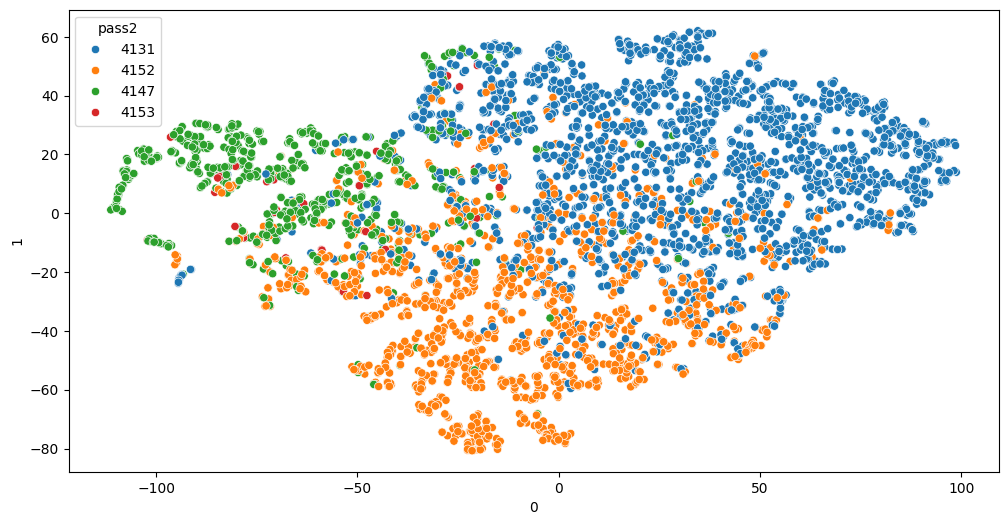

In [ ]:
lc_n2v_tsne_df = n2v_tsne_df.merge(lc_df[["id", "pass2"]], on="id")
lc_n2v_tsne_df["pass2"] = lc_n2v_tsne_df["pass2"].astype(str)

fig, axes = plt.subplots(1, 1, figsize=((12,6)))
ax = sns.scatterplot(x=0, y=1, hue="pass2", data=lc_n2v_tsne_df)

# Spectral clustering <a name="spectral"></a>

Class `SpectralClustering` from `mercury.graph.ml` implements the **unsupervised [spectral clustering algorithm](https://www.sciencedirect.com/topics/computer-science/spectral-clustering)** to group nodes in a graph. This algorithm can work in two modes: "networkx" (running the algorithm locally, with a methodology similar to [scikit-learn's implementation](https://scikit-learn.org/1.5/modules/generated/sklearn.cluster.SpectralClustering.html) but expecting a graph object instead of a numpy array) or "spark" (using PySpark and graphframes).

In [ ]:
from mercury.graph.ml import SpectralClustering

In [ ]:
sc = SpectralClustering(n_clusters=4, mode="spark")

print(sc)

Object of class SpectralClustering.

Initialization parameters: max_iterations=10, mode=spark, n_clusters=4, random_state=0


As with `LouvainCommunities`, cluster assignments are available after fitting through the pandas dataframe `.labels_`, following the `scikit-learn` convention:

In [ ]:
sc.fit(g)

SpectralClustering(max_iterations=10, mode=spark, n_clusters=4, random_state=0)

In [ ]:
sc_df = sc.labels_.toPandas().rename(columns={"node_id": "id"})

sc_df

,id,cluster
0,C564473555,3
1,C638119430,3
2,M692898500,1
3,C1952109278,3
4,M97925176,1
...,...,...
4157,C274387846,0
4158,C1076110991,0
4159,C1213984358,2
4160,C170769685,3


Again, given the size and complexity of the graph, a viable option for visualizing the detected clusters is to color the embedding space created by [SparkNode2Vec](#node2vec) and reduced to two dimensions by using [TSNE](https://scikit-learn.org/1.5/modules/generated/sklearn.manifold.TSNE.html). This approach allows us to verify that the clusters created make sense, although it does not show information on the edges or the structure of the graph.

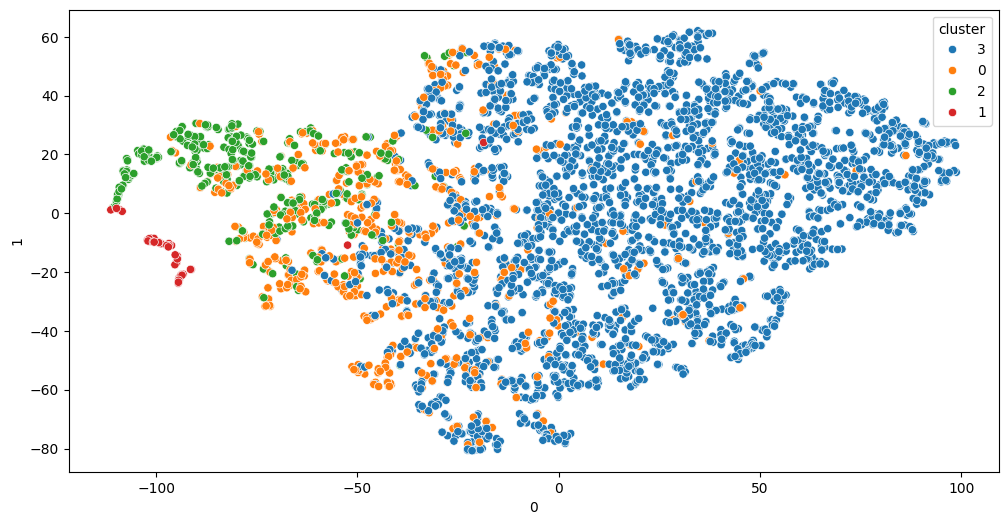

In [ ]:
sc_n2v_tsne_df = n2v_tsne_df.merge(sc_df, on="id")
sc_n2v_tsne_df["cluster"] = sc_n2v_tsne_df["cluster"].astype(str)

fig, axes = plt.subplots(1, 1, figsize=((12,6)))
ax = sns.scatterplot(x=0, y=1, hue="cluster", data=sc_n2v_tsne_df)

**Modularity** is a metric that measures the strength of the division of a graph into clusters. The evolution of modularity for each number of clusters (`k`) can be observed, showing that the division into 2 clusters (potentially fraud/no fraud), although far from ideal, is the best option.

In [ ]:
print(f"Modularity: {sc.modularity_}")

Modularity: -0.38297974908744903


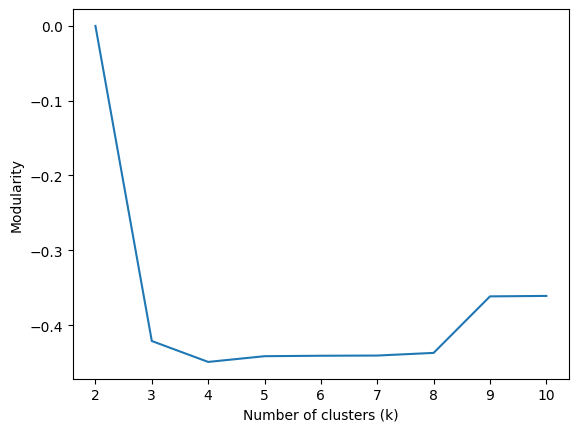

In [ ]:
modularities = []
num_clusters = range(2, 11)

for k in num_clusters:
  modularities.append(
    SpectralClustering(n_clusters=k, mode="spark").fit(g).modularity_
  )

sns.lineplot(x=num_clusters, y=modularities)
plt.xlabel("Number of clusters (k)")
plt.xticks(ticks=num_clusters)
plt.ylabel("Modularity")
plt.show()

Spectral clustering can also be performed using PySpark under the hood by simply passing `mode="spark"` to the constructor, which uses the `Graph` object's graphframe property.

# Transition matrix (Markov chains) <a name="transition"></a>

Class `Transition` of `mercury.graph.ml` can be used to obtain the **transition matrix** of a graph, which computes the distribution of probability of being in each of the nodes (or states) of a directed graph (or Markov process).

In [ ]:
from mercury.graph.ml import Transition

In [ ]:
tm = Transition().fit(g).to_pandas()

tm

,C1000148617,M1053599405,M1400236507,M1741626453,M1823072687,M1842530320,M1888755466,M1946091778,M209847108,M348934600,...,C995844287,C99594781,C996326258,C996804095,C997029022,C99729647,C998690782,C998987490,C999393223,C999723254
C1000148617,0.000000,0.035943,0.029184,0.003631,0.583136,0.021009,0.043517,0.002756,0.011818,0.138548,...,0.000000,0.000000,0.00000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
M1053599405,0.000235,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000270,0.000266,0.00006,0.000159,0.0,0.000233,0.000000,0.000768,0.000404,0.000371
M1400236507,0.001489,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.002381,0.0,0.002157,0.000000,0.000000,0.000000,0.000000
M1741626453,0.000182,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.006462,0.000000,0.00000,0.000000,0.0,0.000000,0.000000,0.000000,0.000686,0.000000
M1823072687,0.000332,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000195,0.000516,0.00012,0.000343,0.0,0.000330,0.000187,0.000448,0.000059,0.000243
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
C99729647,0.000000,0.028788,0.034113,0.000000,0.468406,0.006817,0.000000,0.041448,0.008097,0.250429,...,0.000000,0.000000,0.00000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
C998690782,0.000000,0.000000,0.000000,0.000000,0.144076,0.000000,0.000000,0.000000,0.007679,0.254239,...,0.000000,0.000000,0.00000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
C998987490,0.000000,0.094560,0.000000,0.000000,0.633667,0.000000,0.000000,0.001376,0.000000,0.063779,...,0.000000,0.000000,0.00000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
C999393223,0.000000,0.055548,0.000000,0.012276,0.092885,0.000000,0.000000,0.026377,0.011518,0.488176,...,0.000000,0.000000,0.00000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000


# Spread activation with Spark <a name="spread-activation"></a>

Class `SparkSpreadingActivation` of mercury.graph.ml is a model that represents a **“word-of-mouth” scenario where a node influences its neighbors**, from where the influence spreads to other neighbors, and so on. At the end of the diffusion process (`fit()`), implemented in Spark, the amount of influence received by each node can be inspected through the DataFrame stored in `.influences_`. Using a threshold-based technique, a node that is currently not influenced can be declared to be a potential future one, based on the influence that has been accumulated.

The diffusion model is based on Spreading Activation (SPA) techniques proposed in cognitive psychology and later used for trust metric computations (see paper ["Social Ties and their Relevance to Churn in Mobile Telecom Networks"](https://pdfs.semanticscholar.org/3275/3d80adb5ec2d4a974b5d1a872e2c957b263b.pdf)).

In [ ]:
from mercury.graph.ml import SparkSpreadingActivation

In [ ]:
sa = SparkSpreadingActivation(spreading_factor=0.2, steps=3)

print(sa)

Object of class SparkSpreadingActivation.

Initialization parameters: attribute=influence, influenced_by=False, spreading_factor=0.2, steps=3, transfer_function=weighted


One or more **seed nodes** must be set as the origin of the diffusion process.

In [ ]:
seed_nodes = ["C1093826151"]
sa.fit(g, seed_nodes=seed_nodes)

SparkSpreadingActivation(attribute=influence, influenced_by=False, spreading_factor=0.2, steps=3, transfer_function=weighted)

As mentioned, the **amount of influence received by each node** (the total influence adds up to 1, if there is one seed node) can be inspected through `.influences_`.

In [ ]:
sa.influences_.orderBy(f.col("influence").desc()).show(20, truncate=False)

+-----------+---------------------+
|id         |influence            |
+-----------+---------------------+
|C1093826151|0.5120722093182453   |
|M348934600 |0.354202953411423    |
|M209847108 |0.011846252724231041 |
|M151143676 |0.007619915401045509 |
|M1649169323|0.0053088981323248805|
|M78078399  |0.004436665150874936 |
|M855959430 |0.0024781370511887365|
|M1823072687|0.002171981261953177 |
|M97925176  |0.0020728316524188063|
|M85975013  |2.6095178776199923E-4|
|M732195782 |2.3197919195472945E-4|
|M1053599405|1.83612441375747E-4  |
|M480139044 |1.8264289025458295E-4|
|M980657600 |1.092869061276764E-4 |
|M1913465890|9.494816476951699E-5 |
|M1946091778|9.22343870939663E-5  |
|C747590731 |8.110059570682689E-5 |
|C332611573 |7.907212420268301E-5 |
|C1377339988|7.693324107112887E-5 |
|C447509116 |7.639610023083774E-5 |
+-----------+---------------------+
only showing top 20 rows



In [ ]:
sa.influences_.select(f.sum("influence")).show()

+-----------------+
|   sum(influence)|
+-----------------+
|0.999999999999993|
+-----------------+

